# Engenharia do Conhecimento 2023/2024

## Lab class TP07

# Support Vector Machines

*A Machine Learning Tutorial by Andre Falcao, Nuno Garcia, Sofia Teixeira, Sara C. Madeira, Sara Silva, 2020--2024*

*Other references: book "Introduction to Machine Learning with Python: A Guide for Data Scientists", Sarah Guido&Andreas Müller, 2016, and "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", A. Géron*


### Summary

SVM with scikit learn: Classification and Regression

Classification Exercise - MNIST dataset

Regression Exercise - Diabetes dataset





# Classificadores de vetor de suporte no SKlearn

Vamos usar primeiro o Classificador de Vetor de Suporte Linear (`LinearSVC`) para fazer um classificador simples, usando a estrutura comum do Scikit-Learn. 

Vamos usar o módulo `plot.py` como uma biblioteca para simplificar várias funções de plotagem usando matplotlib

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pandas as pd

import plot
import matplotlib.pyplot as plt


Agora criamos um conjunto de dados simples com 2 características e 250 amostras, muito bem separadas

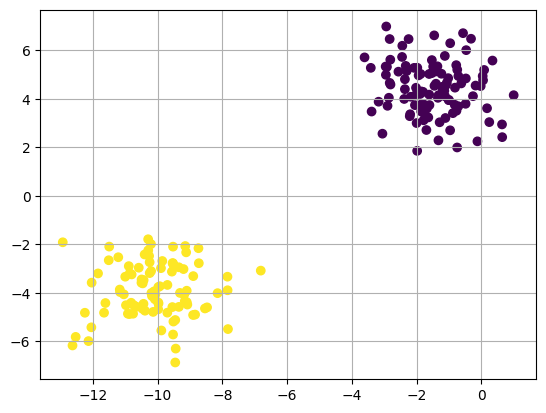

In [4]:

X, y = datasets.make_blobs(
    n_samples=250, n_features=2, centers=2, cluster_std=1.05, random_state=1
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.grid()
plt.show()

Agora vamos ajustar o SVC Linear e traçar o melhor plano de separação entre as 2 classes

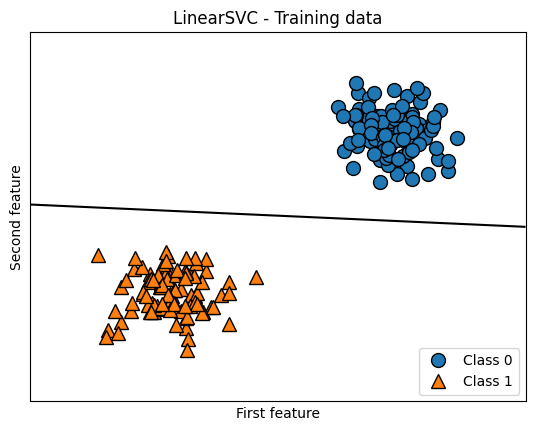

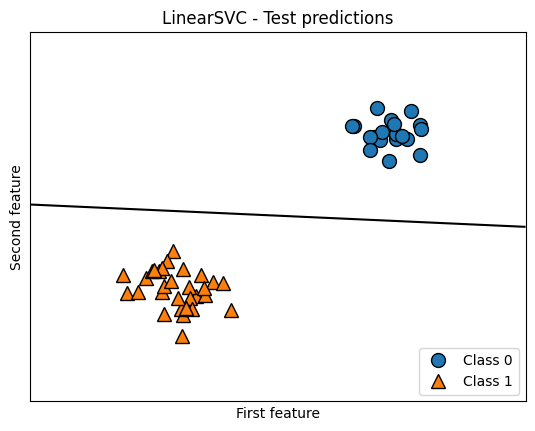

In [5]:
lsvm = LinearSVC(max_iter=5000,dual='auto').fit(X_train, y_train)

#Plot training dataset and separation by LinearSVC
plot.plot_2d_separator(lsvm, X, fill=False)
plot.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.legend(["Class 0", "Class 1"], loc=4)
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.title("LinearSVC - Training data")
plt.show()

#Plot test dataset and predictions made by the model
y_pred=lsvm.predict(X_test)
plot.plot_2d_separator(lsvm, X, fill=False)
plot.discrete_scatter(X_test[:, 0], X_test[:, 1], y_pred)
plt.legend(["Class 0", "Class 1"], loc=4)
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.title("LinearSVC - Test predictions")
plt.show()

## Margens suaves para classificadores de vectores de suporte

No `LinearSVC`, o parâmetro de compensação que determina a força da regularização é chamado $C$.

Com valores mais altos de $C$ há menos regularização e o `LinearSVC` tenta separar todas as amostras negativas das amostras positivas, possivelmente criando uma fronteira de decisão muito fina e, portanto, aumentando o risco de sobreajuste.

Com valores mais baixos de $C$ há mais regularização e `LinearSVC` preocupa-se mais em encontrar uma fronteira de decisão ampla entre amostras positivas e negativas, possivelmente ignorando um número de classificações erradas e, portanto, aumentando o risco de subajuste.


Pode encontrar abaixo uma ilustração, utilizando o `LinearSVC` com diferentes definições de $C$ e uma versão ligeiramente modificada do conjunto de dados `Forge`.

### Apresentando o conjunto de dados Forge

O conjunto de dados `Forge` é um conjunto de dados sintético de classificação simples de duas classes, que tem 26 pontos descritos por duas características. O código a seguir gera o conjunto de dados e cria um gráfico de dispersão visualizando todos os pontos de dados no conjunto de dados. A cor e a forma do ponto identificam a classe.

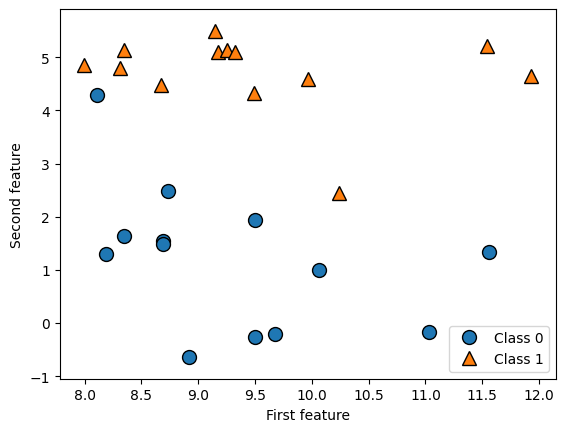

(26, 2)


In [6]:
import numpy as np
from sklearn.datasets import make_blobs

def make_forge():
    # a carefully hand-designed dataset
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def plot_forge(X, y):
    plot.discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(["Class 0", "Class 1"], loc=4)
    plt.xlabel("First feature")
    plt.ylabel("Second feature")
    plt.show()
    
X, y = make_forge()
plot_forge(X,y)
print(X.shape)

### Diferentes valores de C

Podemos examinar o impacto de C na forma geral do classificador testando diferentes possibilidades `[2, 10, 1000]`

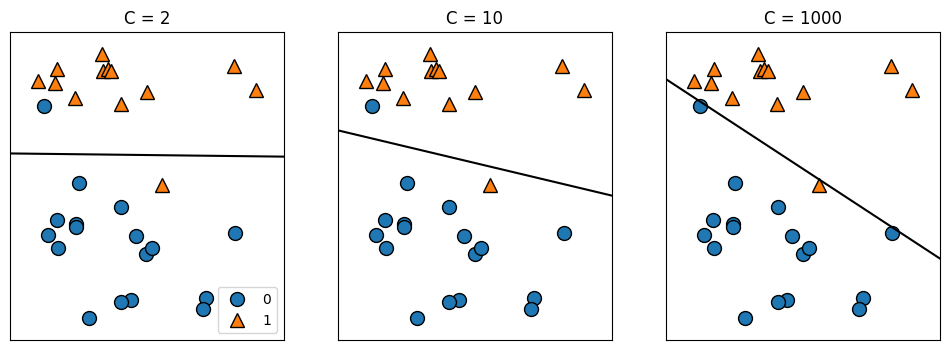

In [7]:

#Example using different values of C

def plot_linear_svc_regularization():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    y[7] = 0
    y[27] = 0
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    for ax, C in zip(axes, [2, 10, 1e3]):
        plot.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)

        svm = LinearSVC(C=C, tol=0.00001, dual=False).fit(X, y)
        w = svm.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(6, 13)
        yy = a * xx - (svm.intercept_[0]) / w[1]
        ax.plot(xx, yy, c='k')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("C = %.0f" % C)
    axes[0].legend(loc="best")

plot_linear_svc_regularization()

### Modelos Lineares para Classificação Multiclasse

Muitos modelos de classificação linear são modelos binários e não se estendem naturalmente ao caso multiclasse. 

Uma técnica comum para alargar um algoritmo de classificação binária a um algoritmo de classificação multiclasse é a abordagem **um-vs-resto**. 

Na abordagem um-vs-rest, é aprendido um modelo binário para cada classe, que tenta separar esta classe de todas as outras classes, resultando em tantos modelos binários quantas as classes.
Para fazer uma previsão, todos os classificadores binários são executados num ponto de teste. O classificador que produzir o valor mais elevado na sua classe única "ganha" e esta etiqueta de classe é devolvida como a previsão no problema multiclasse.

Ter um classificador binário por classe resulta em ter um vetor de coeficientes $w$ e uma interceção $b$ para cada classe. 

A classe para a qual o resultado da seguinte fórmula é mais elevado é a etiqueta de classe atribuída:
\begin{align*}
& w_0.x_0 + w_1.x_1 + \dotsc + w_p . x_p + b. 
\end{align*}


No Scikit-learn, o `LinearSVC` implementa a estratégia multiclasse "um-vs-resto", treinando assim modelos `n_classe`, onde `n_classe` é o número de classes.

Vamos aplicar o `LinearSVC` ao conjunto de dados simples de classificação de três classes `Blobs_V1`.


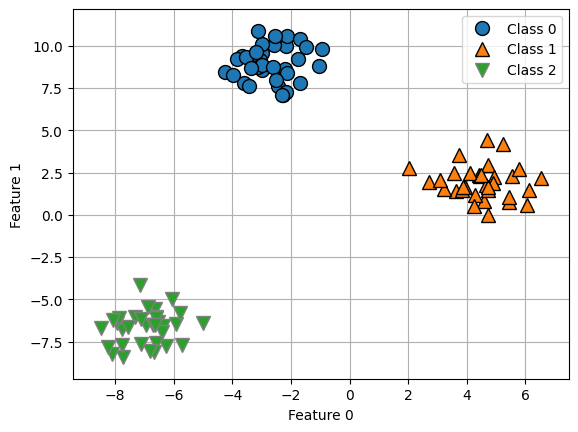

In [8]:
X, y = plot.make_Blobs_V1()
plot.plot_Blobs_V1(X,y)
plt.grid()
plt.show()


Now let's fit a Linear SVC to this dataset

In [9]:
linear_svm = LinearSVC(dual='auto').fit(X, y)
print("Coefficients:")
print(linear_svm.coef_)
print("Intercepts:")
print(linear_svm.intercept_)


Coefficients:
[[-0.17492412  0.23140766]
 [ 0.47622012 -0.06936786]
 [-0.18914207 -0.20400079]]
Intercepts:
[-1.07745775  0.13139239 -0.08604962]


Como podemos ver, a forma de `coef_` é (3, 2), o que significa que cada linha de `coef_` contém o vetor de coeficientes para uma das três classes. Cada linha tem duas entradas, correspondentes às duas características do conjunto de dados. Além disso, `intercept_` é agora uma matriz unidimensional, armazenando os interceptos para cada classe.

Vamos visualizar as linhas aprendidas pelos três classificadores binários:

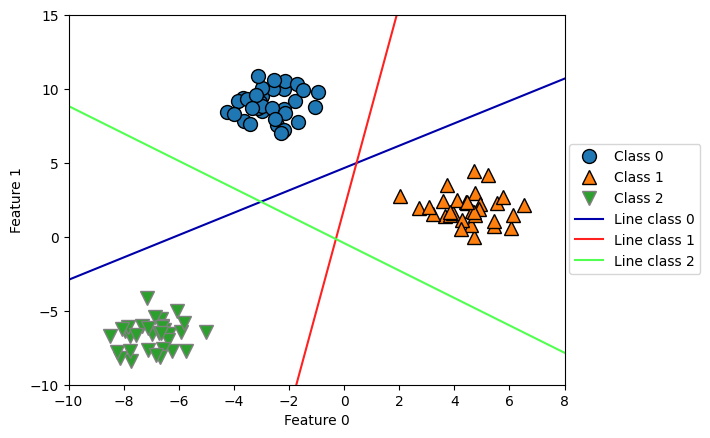

In [10]:

plot.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)

for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, plot.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1', 
            'Line class 2'], loc=(1.01, 0.3))
plt.show()

A linha vermelha mostra o limite de decisão do classificador binário para a classe vermelha, e assim por diante. Pode ver que todos os pontos vermelhos nos dados de treino estão abaixo da linha vermelha, o que significa que estão no lado "vermelho" deste classificador binário. Os pontos vermelhos estão acima da linha verde, o que significa que são classificados como "resto" pelo classificador binário para a classe verde. Os pontos vermelhos estão abaixo da linha azul, o que significa que o classificador binário para a classe azul também os classifica como "repouso". Portanto, qualquer ponto nesta área será classificado como vermelho pelo classificador final (em $w_0.x_0 + w_1.x_1 + \dotsc + w_p . x_p + b$ o valor correspondente ao classificador vermelho é maior que zero, enquanto é menor que zero para as outras duas classes).

**Mas o que é que acontece no triângulo no meio do gráfico? E se tivermos pontos lá? 

Todos os três classificadores binários classificam os pontos aí como "resto". Neste contexto, a que classe seria atribuído um ponto nesse local? 

A resposta é a que tem o valor mais elevado de $w[0] x[0] + w[1] x[1] + \dotsc + w[p] * x[p] + b$, que é a classe da reta mais próxima. 

O mesmo acontece para todas as outras regiões. A figura seguinte mostra a previsão para todas as regiões do espaço 2D.

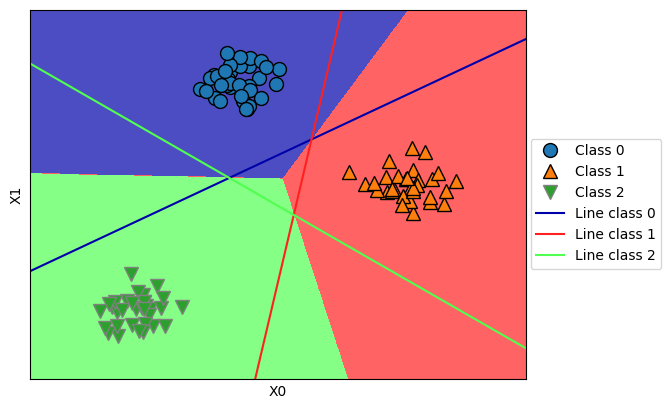

In [11]:
plot.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
plot.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)

for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, plot.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

## Kernelized Support Vector Machines (SVMs)

Na secção anterior, vimos a utilização de SVMs lineares para classificação. 

**As máquinas de vectores de suporte com kernel (muitas vezes referidas apenas como SVMs) são uma extensão das SVMs Lineares que permite modelos mais complexos, que não são definidos simplesmente por hiperplanos no espaço de entrada. 

Embora existam SVMs para classificação e regressão, vamos concentrar-nos no caso da classificação, tal como implementado no `SVC`. Conceitos semelhantes aplicam-se à regressão de vectores de suporte, tal como implementado no `SVR` (ver [SVMs in Scikit-learn](http://scikit-learn.org/stable/modules/svm.html#svm) para mais detalhes).

### Linear Models and Non-Linear Features

Como vimos anteriormente, **os modelos lineares podem ser bastante limitados em espaços de baixa dimensão**, uma vez que as linhas ou os hiperplanos têm uma flexibilidade limitada. 

**Uma forma de tornar um modelo linear mais flexível é adicionar mais características, por exemplo, adicionando interacções ou polinómios das características de entrada**.

Vamos agora olhar para `Blobs_V2`, onde temos duas classes que já não são linearmente separáveis.

(100, 2)


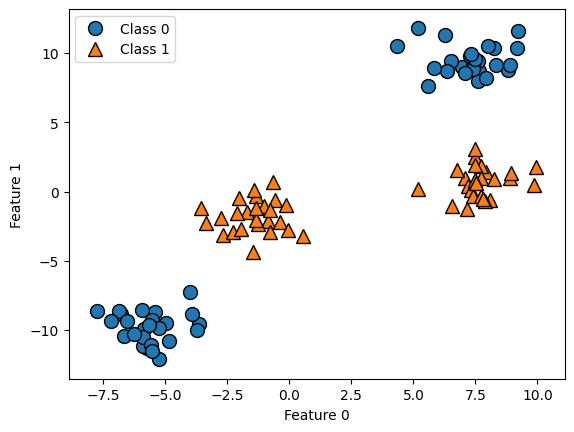

In [12]:
X, y = plot.make_Blobs_V2()
plot.plot_Blobs_V2(X,y)
print(X.shape)

Um modelo linear para classificação, como o `LinearSVC`, só pode separar pontos usando uma linha, e já podemos imaginar que não será capaz de fazer um trabalho muito bom neste conjunto de dados.

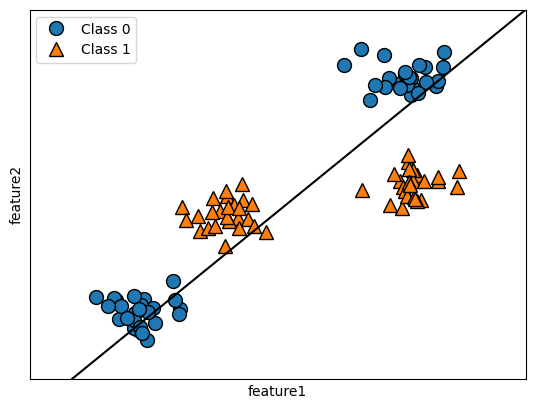

In [13]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC(max_iter=10000,dual='auto').fit(X, y)

plot.plot_Blobs_V2(X,y)
plot.plot_2d_separator(linear_svm, X)
plt.xlabel("feature1")
plt.ylabel("feature2")
plt.show()

Vamos agora expandir o conjunto de características de entrada, por exemplo, adicionando também $característica2^2$, o quadrado da segunda caraterística, como uma nova caraterística. 

Em vez de representar cada ponto de dados como um ponto bidimensional $(característica1, característica2)$, representamo-lo agora como um ponto tridimensional $(característica1, característica2, característica2^2)$ (esta caraterística em particular foi escolhida para fins ilustrativos e a escolha não é particularmente importante). 

Esta nova representação é ilustrada abaixo num gráfico de dispersão tridimensional.

In [14]:
# Data Augmentation:

# squared first feature
print(X[:10,:])
X_new = np.hstack([X, X[:, 1:] ** 2])
# squared second feature
X_new1 = np.hstack([X, X[:, :1] ** 2])
# first feature times second feature
X_new2 = np.hstack([X, X[:, 1:] * X[:, :1]])
#show first 10 rows <- now a 3 Dimensional dataset
print(X_new[:10,:])
print(X_new1[:10,:])
print(X_new2[:10,:])


[[ -1.72161036  -1.48033142]
 [ -3.6573384   -9.5482383 ]
 [  7.0778163    0.99508772]
 [ -1.36579859  -0.3148625 ]
 [ -2.66521206  -3.12591651]
 [  7.63027116   8.69797933]
 [ -5.27144331 -12.11880698]
 [  7.91767139   1.41547387]
 [ -1.41284184   0.11296348]
 [ -1.01519039  -1.03318203]]
[[-1.72161036e+00 -1.48033142e+00  2.19138111e+00]
 [-3.65733840e+00 -9.54823830e+00  9.11688546e+01]
 [ 7.07781630e+00  9.95087718e-01  9.90199567e-01]
 [-1.36579859e+00 -3.14862498e-01  9.91383928e-02]
 [-2.66521206e+00 -3.12591651e+00  9.77135405e+00]
 [ 7.63027116e+00  8.69797933e+00  7.56548444e+01]
 [-5.27144331e+00 -1.21188070e+01  1.46865483e+02]
 [ 7.91767139e+00  1.41547387e+00  2.00356628e+00]
 [-1.41284184e+00  1.12963480e-01  1.27607478e-02]
 [-1.01519039e+00 -1.03318203e+00  1.06746511e+00]]
[[ -1.72161036  -1.48033142   2.96394225]
 [ -3.6573384   -9.5482383   13.3761242 ]
 [  7.0778163    0.99508772  50.09548364]
 [ -1.36579859  -0.3148625    1.86540579]
 [ -2.66521206  -3.12591651   

Agora mostre os dados 3D, onde podemos ver que são trivialmente separáveis

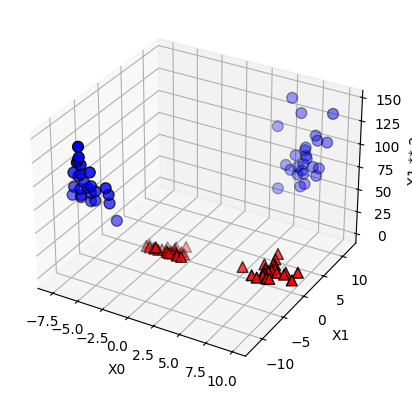

In [15]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')
ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X1 ** 2")
plt.show()

Como podemos ver, **nesta nova representação tridimensional dos dados, é de facto possível separar os pontos vermelhos dos azuis utilizando um modelo linear, um plano em três dimensões**. 

Podemos confirmar este facto ajustando um modelo linear a estes dados aumentados.

In [16]:
linear_svm_3d = LinearSVC(max_iter=10000,dual='auto').fit(X_new, y)

e observando o seu limite de decisão (**mais uma vez não se preocupe com o código**, o importante é compreender o que está a acontecer com os dados e o modelo).

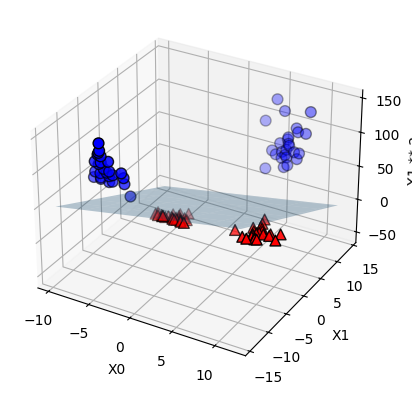

In [17]:
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary

xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
mask = y == 0


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',  s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')


ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X1 ** 2")
plt.show()


**Embora o modelo SVM linear seja linear no espaço de características transformado, quando representado no espaço de características original tem a forma de uma parábola**, como podemos ver no gráfico abaixo.

Text(0, 0.5, 'Feature 1')

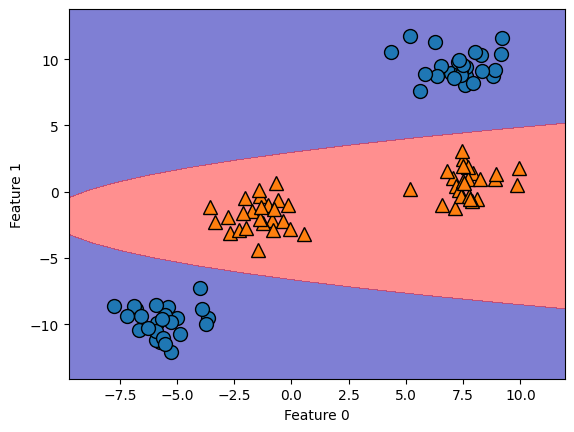

In [18]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=plot.cm2, alpha=0.5)
plot.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### Exercício 1
1.1 Comente os resultados acima

1.2 Volte atrás e aplique duas Ampliações de Dados diferentes: uma que usa a outra caraterística; outra que usa ambas as características.

Os resultados acima demonstram uma boa separação aquando é adiconada mais uma caracterstica, uma vez que como é visivel, os dados não são linearmente separáveis.
 A adição de uma nova característica, neste caso a característica 1 ao quadrado, permite que os dados sejam separados de forma uniforme.
[[ -1.72161036  -1.48033142   2.96394225]
 [ -3.6573384   -9.5482383   13.3761242 ]
 [  7.0778163    0.99508772  50.09548364]
 [ -1.36579859  -0.3148625    1.86540579]
 [ -2.66521206  -3.12591651   7.10335532]
 [  7.63027116   8.69797933  58.22103805]
 [ -5.27144331 -12.11880698  27.78811454]
 [  7.91767139   1.41547387  62.68952022]
 [ -1.41284184   0.11296348   1.99612207]
 [ -1.01519039  -1.03318203   1.03061152]]


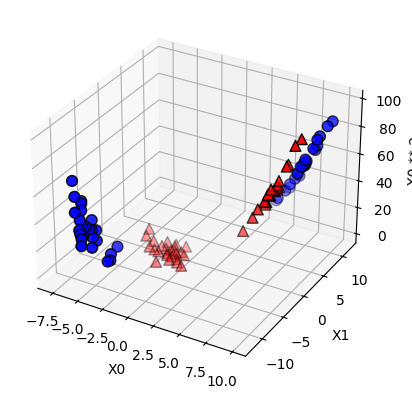

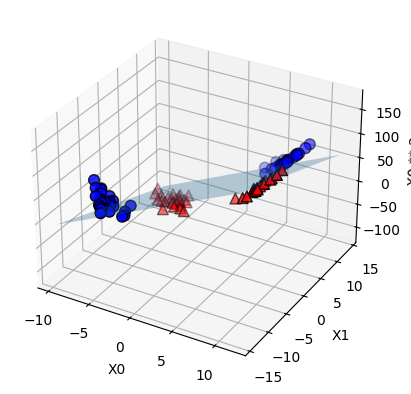

Text(0, 0.5, 'Feature 1')

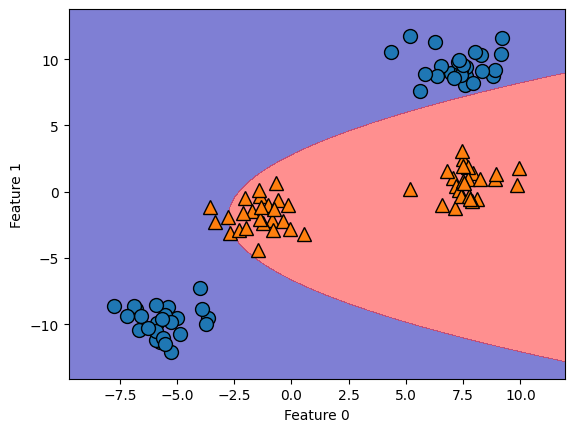

In [20]:
# 1.1 
print("Os resultados acima demonstram uma boa separação aquando é adiconada mais uma caracterstica, uma vez que como é visivel, os dados não são linearmente separáveis.\n A adição de uma nova característica, neste caso a característica 1 ao quadrado, permite que os dados sejam separados de forma uniforme.")
# 1.2

# 1.2

# squared second feature
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from mpl_toolkits.mplot3d import Axes3D

X_new = np.hstack([X, X[:, 0:1] ** 2])

print(X_new[:10, :])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mask = y == 0

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X0 ** 2")
plt.show()

linear_svm_3d = LinearSVC(max_iter=10000, dual='auto').fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)

ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the decision boundary surface
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)

# Plot the data points with different colors based on the mask
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',  s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X0 ** 2")
plt.show()

ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=plot.cm2, alpha=0.5)
plot.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

[[ -1.72161036  -1.48033142   2.54855392]
 [ -3.6573384   -9.5482383   34.9211386 ]
 [  7.0778163    0.99508772   7.04304808]
 [ -1.36579859  -0.3148625    0.43003876]
 [ -2.66521206  -3.12591651   8.33123039]
 [  7.63027116   8.69797933  66.36794087]
 [ -5.27144331 -12.11880698  63.88360393]
 [  7.91767139   1.41547387  11.20725698]
 [ -1.41284184   0.11296348  -0.15959953]
 [ -1.01519039  -1.03318203   1.04887646]]


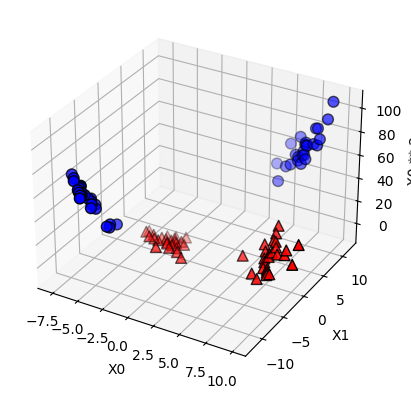

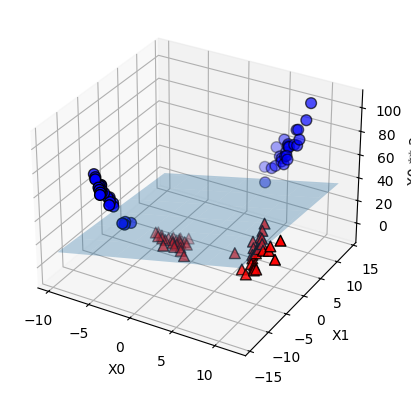

Text(0, 0.5, 'Feature 1')

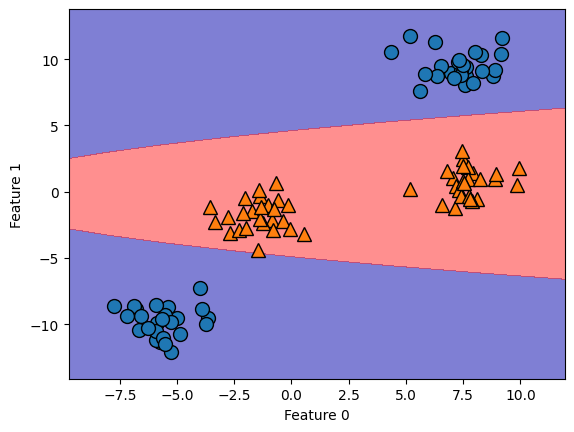

In [21]:

# 1.2
X_new = np.hstack([X, (X[:, 0] * X[:, 1]).reshape(-1, 1)])

# Show first 10 rows
print(X_new[:10, :])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define the mask based on the labels
mask = y == 0

# Plot the data points with different colors based on the mask
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X0 ** 2")
plt.show()

# Fit a linear SVM on the augmented dataset
linear_svm_3d = LinearSVC(max_iter=10000, dual='auto').fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# Define a grid for plotting the decision boundary
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)

# Calculate the decision boundary in the new feature space
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the decision boundary surface
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)

# Plot the data points with different colors based on the mask
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',  s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X0 ** 2")
plt.show()

ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=plot.cm2, alpha=0.5)
plot.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")


### The Kernel Trick


Felizmente, **existe um truque matemático inteligente que nos permite aprender um classificador num espaço dimensional mais elevado sem calcular efetivamente a nova representação, possivelmente muito grande.** Este truque é conhecido como o **Truque do Kernel**.

**O truque do kernel funciona calculando diretamente a distância (mais precisamente, os produtos escalares) dos pontos de dados para a representação expandida das características, sem nunca calcular a expansão.

Existem duas formas de mapear dados num espaço dimensional mais elevado que são normalmente utilizadas com SVMs (embora existam outros kernels - [Kernels in Scikit-Learn](http://scikit-learn.org/stable/modules/svm.html#svm-kernels)): 
* O Kernel Polinomial**, que calcula os polinómios possíveis até um certo grau das características originais (mais ou menos o que vimos acima)
* O kernel RBF (Radial Basis Function)**, também conhecido como kernel Gaussiano**, que considera possíveis polinómios de todos os graus, mas a importância das características diminui para graus mais elevados.

## Understanding SVMs

**Durante o treino**, a SVM aprende a importância de cada um dos pontos de dados de treino para representar a fronteira de decisão entre as duas classes. Normalmente, apenas um subconjunto dos pontos de treino é importante para definir a fronteira de decisão: os que se encontram na fronteira entre as classes. Estes são designados por **Vectores de Apoio** e dão o nome ao SVM.

**Para fazer uma previsão para um novo ponto**, é medida a distância aos vectores de suporte. A decisão de classificação é feita com base na distância aos vectores de suporte, e na importância dos vectores de suporte que foi aprendida durante o treino (armazenada no atributo `dual_coef_` do `SVC`).

Por exemplo, é assim que a distância entre os pontos de dados é medida pelo núcleo Gaussiano: 
\begin{align*}
&k_\text{rbf}(x_1, x_2) = e^{-\gamma||x_1 - x_2||^2}, &
\end{align*}
em que $x_1$ e $x_2$ são pontos de dados, $||x_1 - x_2 ||$ representa a distância euclidiana e $\gamma$ (gama) é um parâmetro que controla a largura do núcleo gaussiano.

**Vamos agora treinar um SVM no conjunto de dados `Forge`.** 

Note que vamos ajustar apenas dois parâmetros, o parâmetro $C$, que já conhecemos, e o parâmetro $gamma$, que discutiremos em pormenor mais adiante.

In [22]:
from sklearn.svm import SVC
X, y = make_forge()  

svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)


**No gráfico abaixo, o limite de decisão é apresentado a preto e os vectores de apoio são os pontos grandes com arestas grossas.**

Neste caso, o SVM produz um limite muito suave e não linear (não uma linha reta).

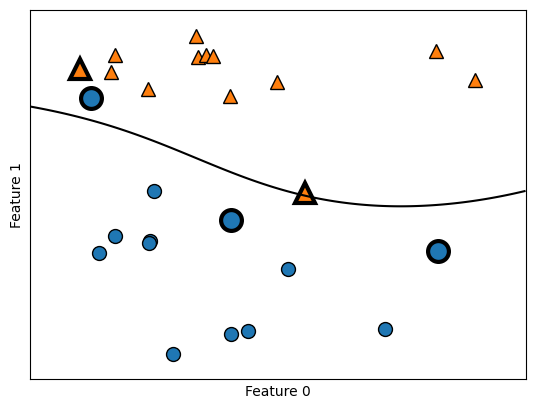

In [23]:
plot.plot_2d_separator(svm, X, eps=.5)
plot.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_

# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
plot.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.grid()
plt.show()

In [24]:
print("The support vector coordinates are:")
print(sv)

The support vector coordinates are:
[[ 8.1062269   4.28695977]
 [ 9.50169345  1.93824624]
 [11.563957    1.3389402 ]
 [10.24028948  2.45544401]
 [ 7.99815287  4.8525051 ]]


## Tuning SVM parameters

**O parâmetro $gamma$ controla a largura do Kernel Gaussiano**. Determina a escala do que significa os pontos estarem próximos uns dos outros. O parâmetro $C$ é um parâmetro de regularização semelhante ao dos modelos lineares. Controla a importância de cada ponto (ou mais precisamente, o seu `dual_coef_`).

**Vamos ver o que acontece quando variamos estes parâmetros**. 

Vamos usar a função `plot_svm` abaixo para nos ajudar. **Mais uma vez, não se preocupe com este código.**

In [25]:
def plot_svm(X, y, log_C, log_gamma, ax=None):
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    plot.plot_2d_separator(svm, X, ax=ax, eps=.5)
    # plot data
    plot.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    # plot support vectors
    sv = svm.support_vectors_
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svm.dual_coef_.ravel() > 0
    plot.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, ax=ax)
    ax.set_title("C = %.1f gamma = %.1f" % (C, gamma))

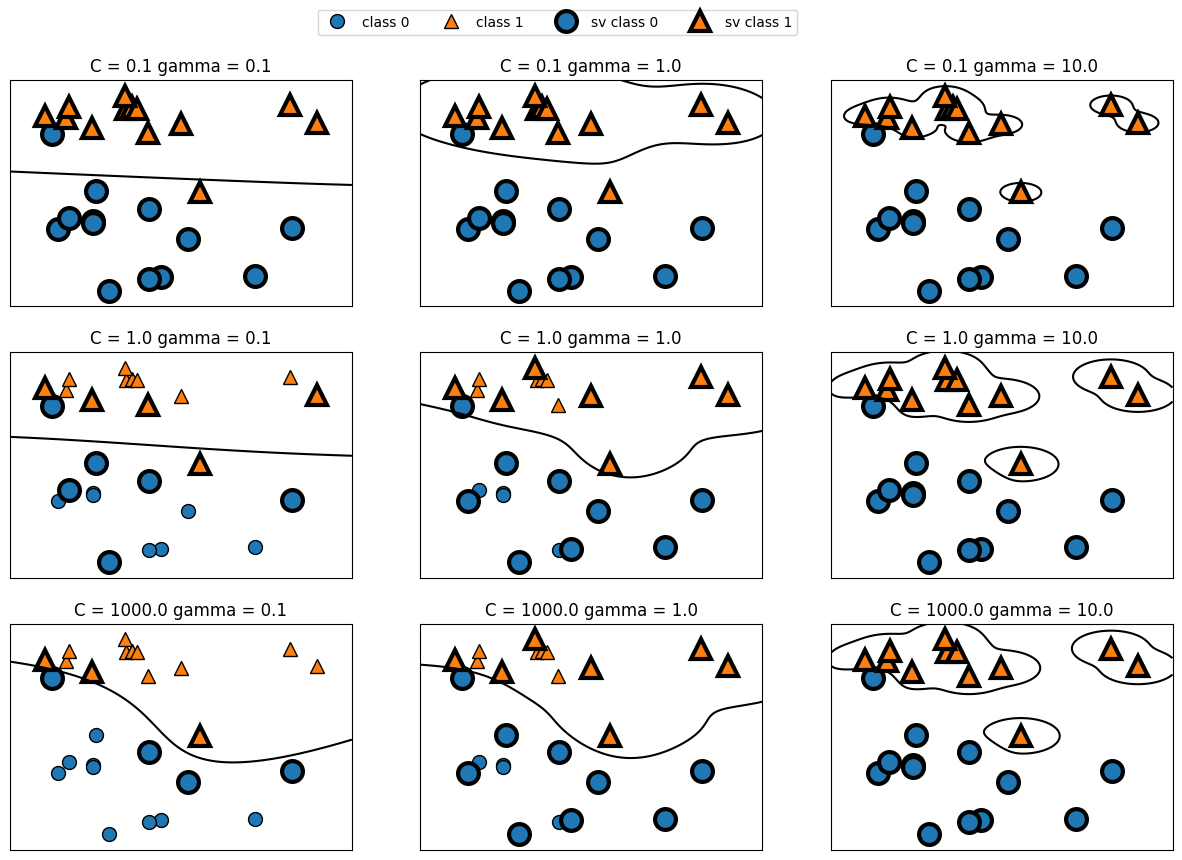

In [26]:
X, y = make_forge()

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(X, y, log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))
plt.show()

**Vamos aplicar o kernel RBF SVM ao conjunto de dados de cancro da mama**. Por defeito, $C=1$ e `gamma=1/n_features`.

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, shuffle=True, random_state=0)

svc = SVC(gamma='auto').fit(X_train, y_train)


In [28]:
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

print("F1 on training set:", f1_score(y_train, pred_train))
print("F1 on test set: ", f1_score(y_test, pred_test))

F1 on training set: 1.0
F1 on test set:  0.7403314917127072


Como se pode ver, **o modelo sobreajusta-se substancialmente**, com uma pontuação perfeita no conjunto de treino e F1 de apenas 0,74 no conjunto de teste.

**Embora os SVMs tenham frequentemente um bom desempenho, são muito sensíveis às definições dos parâmetros e também ao escalonamento dos dados. Em particular, têm um desempenho muito melhor quando todas as características variam numa escala semelhante**. 

Vejamos os valores mínimos e máximos de cada caraterística, representados no espaço logarítmico:

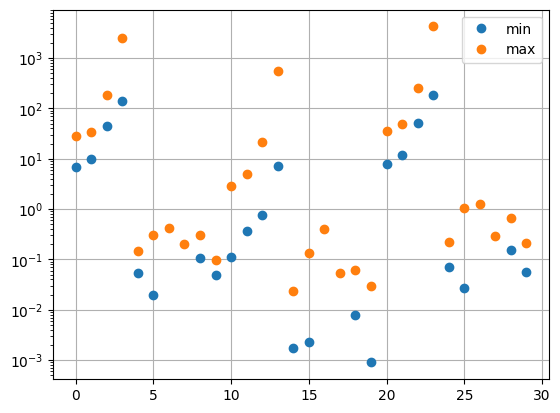

In [29]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), 'o', label="max")
plt.legend(loc="best")
plt.grid()
plt.yscale("log")

A partir deste gráfico podemos observar que as **características** no conjunto de dados `Cancro da mama` **são de ordens de grandeza completamente diferentes**. Isto pode ser um problema para outros modelos (como os modelos lineares), mas tem **efeitos devastadores para o SVM de kernel**.

## Preprocessing Data for SVMs

Uma forma de resolver este problema é redimensionar cada caraterística, de modo a que estejam aproximadamente na mesma escala. 

**Um método de reescalonamento comum para SVMs de kernel consiste em escalonar os dados de modo a que todas as características estejam entre zero e um.**

Vamos escalar as características do conjunto de dados `Cancer` de modo a que todas as características estejam entre zero e um utilizando o nosso conhecido `MinMaxScaler`

In [30]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[-2.01940374 -2.27298803 -1.97758927 -1.42637934 -3.17634419 -1.66431173
 -1.12569574 -1.26287094 -2.73822471 -1.86571828 -1.02452182 -1.56951437
 -1.0160812  -0.69335245 -1.86246228 -1.3042055  -1.0129125  -1.97706948
 -1.54421953 -1.08004989 -1.70435952 -2.21839784 -1.67360765 -1.18820113
 -2.71180676 -1.46835588 -1.34136004 -1.75401433 -2.12827758 -1.59890274]
Maximum for each feature
 [ 3.96362762  3.52810408  3.98091912  5.16300591  3.50304585  4.12577731
  4.36609705  3.95564407  4.49656115  5.10502068  8.69708777  6.78861237
  9.41028144 10.52718237  5.74771792  6.30837677 11.73185539  6.98449383
  4.99967235 10.02359555  4.04978287  3.93855484  4.26131521  5.75809625
  3.98837355  5.27090871  4.93690979  2.69509633  5.9340515   6.9689873 ]


Com o escalonador ajustado, também podemos transformar o conjunto de teste
(repare como os intervalos se desviam do conjunto de treino)

In [31]:

X_test_scaled = scaler.transform(X_test)
print("Minimum for each feature\n{}".format(X_test_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_test_scaled.max(axis=0)))

Minimum for each feature
[-1.80759497 -1.98413697 -1.80506388 -1.32771325 -2.22380383 -1.37482711
 -1.12569574 -1.26287094 -2.21571239 -1.8246103  -0.99952692 -1.56600473
 -0.97117852 -0.7022874  -1.47063499 -1.21878779 -1.0129125  -1.97706948
 -1.26965406 -0.956451   -1.49269878 -1.87707424 -1.47379651 -1.09089014
 -2.14014771 -1.34477883 -1.34136004 -1.75401433 -2.0678856  -1.39602931]
Maximum for each feature
 [2.3099335  4.84478349 2.51095333 2.39029322 4.85967226 4.79991959
 4.3609501  3.46543565 4.00693423 4.74973028 3.40591297 4.5018017
 4.05045406 2.85696863 8.49367738 3.92308422 3.6151118  4.96606254
 7.13586013 6.98924666 2.48586797 3.17221771 2.94894619 2.56561294
 2.55480133 4.02925359 4.5257132  2.70582446 4.03011493 3.3498602 ]


Vamos agora treinar e avaliar o `SVM` nos dados escalados.

In [32]:
svc_scaled = SVC(gamma='auto').fit(X_train_scaled, y_train)
pred_train=svc_scaled.predict(X_train_scaled)
pred_test=svc_scaled.predict(X_test_scaled)

print("F1 on training set:", f1_score(y_train, pred_train))
print("F1 on test set: ", f1_score(y_test, pred_test))

F1 on training set: 0.9880341880341881
F1 on test set:  0.9852941176470589


O escalonamento dos dados fez uma enorme diferença! O desempenho do conjunto de treino e de teste é bastante semelhante. Mas será que podemos fazer melhor?

Podemos tentar aumentar $C$ ou $gamma$ para obter um modelo mais complexo e mais preciso.

In [33]:
svc_scaled = SVC(C=100,gamma='auto').fit(X_train_scaled, y_train)

pred_train=svc_scaled.predict(X_train_scaled)
pred_test=svc_scaled.predict(X_test_scaled)

print("F1 on training set:", f1_score(y_train, pred_train))
print("F1 on test set: ", f1_score(y_test, pred_test))

F1 on training set: 1.0
F1 on test set:  0.9538461538461539


In [34]:
svc_scaled = SVC(C=1000,gamma='auto').fit(X_train_scaled, y_train)

pred_train=svc_scaled.predict(X_train_scaled)
pred_test=svc_scaled.predict(X_test_scaled)

print("F1 on training set:", f1_score(y_train, pred_train))
print("F1 on test set: ", f1_score(y_test, pred_test))

F1 on training set: 1.0
F1 on test set:  0.9538461538461539


O aumento de $C$ permitiu-nos melhorar significativamente o modelo, resultando numa precisão de 98,5% no conjunto de teste.

### Exercício 2
Volte atrás e substitua o MinMaxScaler pelo StandardScaler. O que acontece com os resultados? Qual é o efeito de aumentar $C$ neste caso?  

Ao mudar o Scaler notamos uma diferença no range dos dados. Este já não se encontra entre 0 e 1. Notamos também que o F1 no training set vai aumentando à medida que o C aumenta mas o F1 do test set dimiinui, o que pode estar a acontecer à medida que se aumenta o C, estamos a aumentar a probabilidade de overfit dai o F1 do training ficar a 1, mas do test estagnar num ponto.

## Multiclass Classification using SVMs

Como vimos acima, no Scikit-learn o `LinearSVC` implementa a estratégia multiclasse "um-vs-resto", treinando assim `n_modelos de classe`. Se houver apenas duas classes, apenas um modelo é treinado.

Por outro lado **`SVC` implementa a abordagem "um-contra-um "** (Knerr et al., 1990) para classificação multiclasse. Se `n_classe` for o número de classes, os classificadores `n_classe * (n_classe - 1) / 2` são construídos e cada um treina dados de duas classes. 

**Classificação multiclasse com SVMs no Scikit-learn (http://scikit-learn.org/stable/modules/svm.html#multi-class-classification).**

# SVM Regression

Primeiro, vamos criar um conjunto de dados simples com uma variável independente

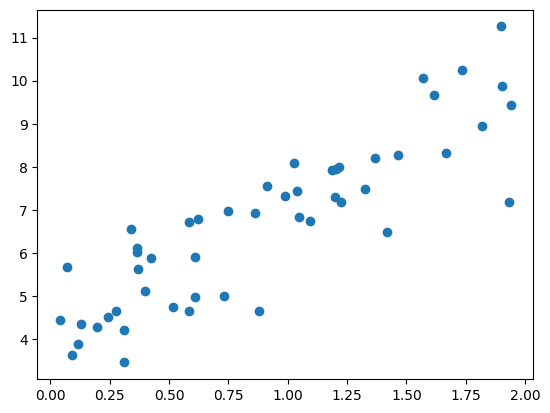

In [33]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()
plt.scatter(X,y)
plt.show()

Agora, para efeitos de visualização, vamos ajustar duas SVRs lineares, uma com um $\epsilon=1,5$, a outra, um hipertubo mais estreito com $\epsilon = 0,5$

In [34]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, dual='auto', random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, dual='auto', random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Agora vamos desenhar ambos

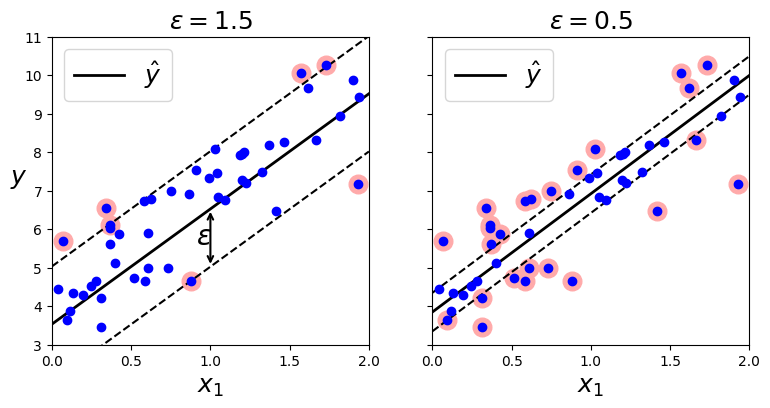

In [35]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

## Ajuste de curvas não lineares com núcleos polinomiais em Regressão

Vamos criar um conjunto de dados parabólico com uma variável independente

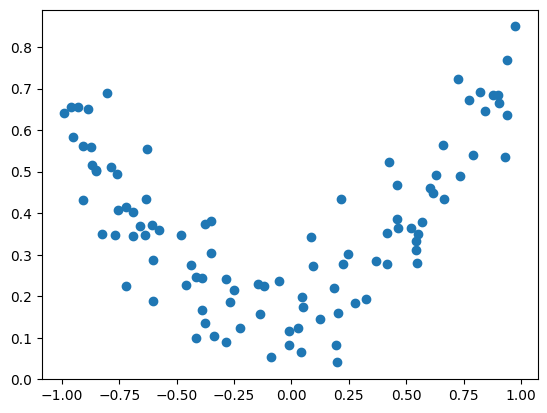

In [36]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()
plt.scatter(X,y)
plt.show()

Vamos agora verificar como se comportam dois épsilons diferentes e os seus impactos graficamente

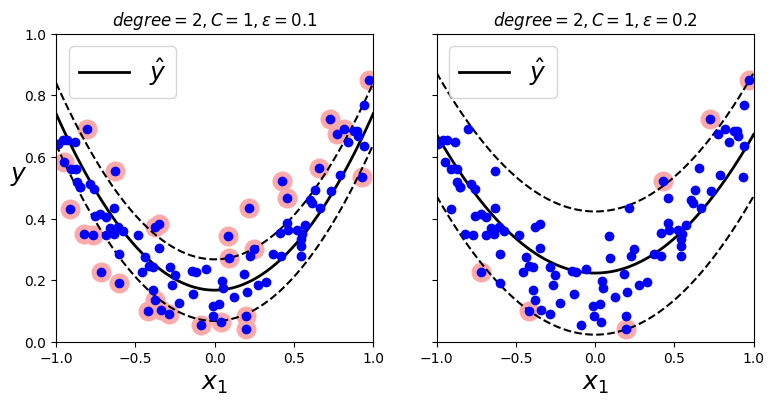

In [37]:
from sklearn.svm import SVR

#first fit model
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=1, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=1, epsilon=0.2, gamma="scale")
svm_poly_reg1 = svm_poly_reg1.fit(X, y)
svm_poly_reg2 = svm_poly_reg2.fit(X, y)

#now plot stuff
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon))
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon))
plt.show()

### Exercício 3
3.1 Verificar a qualidade de ambos os modelos acima com validação cruzada simples

3.2 Qual é o melhor Epsilon para essa partição de dados? Apresente um gráfico que suporte a sua escolha.


In [38]:
X_train, X_test, y_train, y_test = train_test_split( X,y, random_state=0, test_size=0.2)


from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

def present_reg_statistics(y_test, preds):
    corr=r2_score(y_test, preds)
    print("The R2 is: %6.2f"%corr)
    print("The rmse is: ", mean_squared_error(y_test, preds, squared=True))
    

In [39]:
#Start here for exercise 3.1
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

## Primeiro
scores = cross_val_score(svm_poly_reg1, X, y, cv=5)

print("Scores de validação cruzada: ", scores)
print("Média dos scores: ", scores.mean())

## Segundo

scores2 = cross_val_score(svm_poly_reg2, X, y, cv=5)

print("Scores de validação cruzada: ", scores2)
print("Média dos scores: ", scores2.mean())

Scores de validação cruzada:  [0.87079535 0.73039459 0.69107791 0.58578781 0.63463964]
Média dos scores:  0.7025390594680101
Scores de validação cruzada:  [0.75312337 0.73773718 0.69107184 0.56508309 0.64164707]
Média dos scores:  0.6777325086520308


Melhor: 0.705445 usando {'epsilon': 0.08}


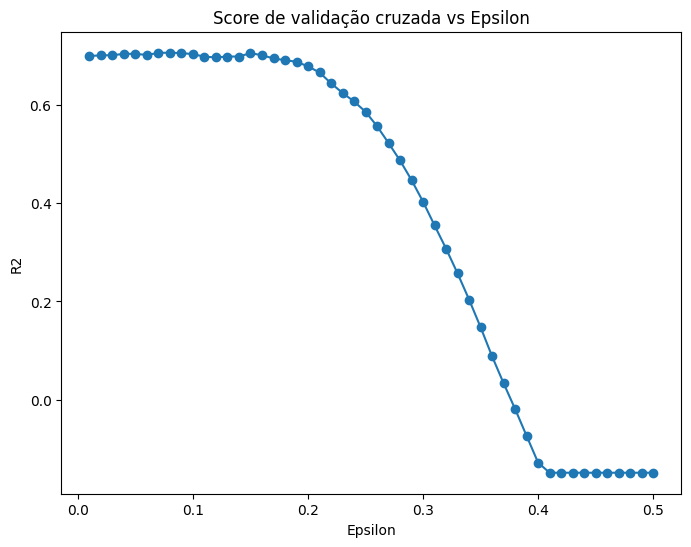

In [40]:
#Exercise 3.2
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
# Definir os valores de Epsilon para testar
epsilon = np.linspace(0.01, 0.5, 50)
# Definir o grid de busca
grid = dict(epsilon=epsilon)
# Definir a busca em grid
grid_search = GridSearchCV(estimator=svm_poly_reg1, param_grid=grid, cv=5, scoring="r2")
# Executar a busca em grid
grid_result = grid_search.fit(X, y)
# Apresentar o melhor Epsilon
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(epsilon, means,marker = 'o')
plt.title('Score de validação cruzada vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('R2')
plt.show()


### Exercise 4

Vai treinar um classificador SVM no conjunto de dados MNIST. Uma vez que os classificadores SVM são classificadores binários, terá de utilizar um-versus-todos para classificar os 10 dígitos. Pode querer afinar os hiperparâmetros utilizando pequenos conjuntos de validação para acelerar o processo. Qual é o F1 que consegue atingir? (utilize a 'macro' F1 para classificação multiclasse)

Primeiro, vamos carregar o conjunto de dados e dividi-lo em um conjunto de treinamento e um conjunto de teste.

Poderíamos usar `train_test_split()` mas as pessoas normalmente só pegam as primeiras 60.000 instâncias para o conjunto de treinamento e as últimas 10.000 instâncias para o conjunto de teste (isso torna possível comparar o desempenho do seu modelo com outros). Mas isso demora muito tempo, por isso deixamo-lo como um exercício extra para fazer em casa.

Aqui e agora, use as primeiras 6000 instâncias para treinar e as últimas 2000 para testar, de acordo com o código abaixo: 

In [41]:
from sklearn.datasets import fetch_openml
#The line below with the "parser" option may be important for some versions of sklearn

#X, y = fetch_openml('mnist_784', version=1, cache=True, return_X_y=True, parser='liac-arff')
X, y = fetch_openml('mnist_784', version=1, cache=True, return_X_y=True, parser='auto')
X=X.values
y=y.values
X_train = X[:6000]
y_train = y[:6000]
X_test = X[68000:]
y_test = y[68000:]

Vamos começar de forma simples, com um classificador SVM linear. Ele usará automaticamente a estratégia Um-vs-Todos (também chamada de Um-vs-Resto, OvR), portanto não há nada de especial que precisemos fazer. Fácil!

**Aviso**: Quando você usa 60.000 instâncias para treinamento, isso pode levar alguns minutos, dependendo do seu hardware.

In [42]:
from time import time
lin_clf = LinearSVC(max_iter=60000, dual='auto', random_state=42)

t1=time()
lin_clf.fit(X_train, y_train)
print ("It took %7.4f seconds" % (time()-t1))

Vamos fazer previsões nos conjuntos de treino e de teste e medir a pontuação F1:

In [ ]:
y_pred_train = lin_clf.predict(X_train)
y_pred_test = lin_clf.predict(X_test)

print("F1 on training data:", f1_score(y_train, y_pred_train,average='macro'))
print("F1 on test data:", f1_score(y_test, y_pred_test,average='macro'))


F1 on training data: 0.9996463605123399
F1 on test data: 0.8550658493106867


Ora bem, o resultado produzido para este conjunto de dados clássico não é assim tão bom, uma vez que os modelos regulares obtêm classificadores quase perfeitos.

#### Melhore estes resultados!




In [ ]:
#Continue here!
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=5000, dual=False, random_state=42))
])
# Define hyperparameters for GridSearchCV
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10]
}
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
t1 = time()
grid_search.fit(X_train, y_train)
print("GridSearchCV took %7.4f seconds" % (time() - t1))
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
# Train the best model on the full training data
best_model.fit(X_train, y_train)
# Predictions on training and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
# Evaluate F1 score on training and test data
print("F1 on training data:", f1_score(y_train, y_pred_train, average='macro'))
print("F1 on test data:", f1_score(y_test, y_pred_test, average='macro'))

GridSearchCV took 1424.0241 seconds
F1 on training data: 0.9627606847447421
F1 on test data: 0.9137548510684574


### Exercício 5

5.1. Treine e afine uma SVM para o conjunto de dados da diabetes. Verifique os Kernels, C, Epsilon e Gamma. Verifique também se os dados estão escalados; se não estiverem, podem precisar de ser escalados
    
5.2. **Extra**, não para avaliação: Treinar um regressor SVM no conjunto de dados de habitação da Califórnia e testar os parâmetros predefinidos para todos os kernels


In [ ]:
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y =True)

X_train, X_test, y_train, y_test = train_test_split( X,y, random_state=0, test_size=0.2)

#continue here:


Para o Exercício 5.2, vamos carregar o conjunto de dados utilizando a função `fetch_california_housing()` do Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [ ]:
# Continue here